### Exponentially-Weighted Moving Average

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r"C:\Users\Emilie Berger\Downloads\airline_passengers.csv", index_col='Month', parse_dates=True)
df.head()

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

In [3]:
df.isna().sum()

Passengers    0
dtype: int64

<AxesSubplot:xlabel='Month'>

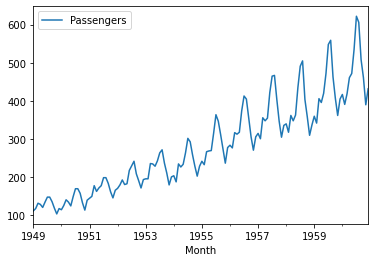

In [4]:
df.plot()

In [5]:
#trend compenent (going upwards), cyclical component (periodicity, pattern) not constant
alpha = 0.2 #random

#ewma
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

In [6]:
df.plot()

# delayed and damped version of the original dataset

<AxesSubplot:xlabel='Month'>

<AxesSubplot:xlabel='Month'>

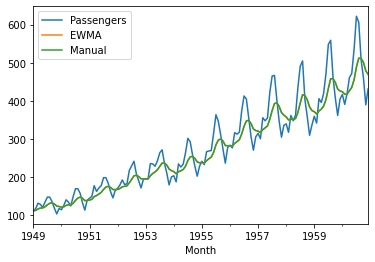

In [7]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
    if len(manual_ewma) > 0:
        xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
    else:
        xhat = x
    manual_ewma.append(xhat)
df['Manual'] = manual_ewma
df.plot()

In [8]:
#good match

df.head()

Passengers      EWMA    Manual
Month                                     
1949-01-01         112  112.0000  112.0000
1949-02-01         118  113.2000  113.2000
1949-03-01         132  116.9600  116.9600
1949-04-01         129  119.3680  119.3680
1949-05-01         121  119.6944  119.6944

In [9]:
df.drop('Manual', axis=1, inplace=True)

### Simple Exponential Smoothing

In [10]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing #from Holt-Winters module in statsmodels

In [11]:
ses = SimpleExpSmoothing(df['Passengers'])

# No frequency information was provided, so inferred frequency MS will be used.
# --> when df loaded, pandas did not automatically assign a frequency to index

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [12]:
# link to offset aliases docs https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [13]:
# freq=None -->

df.index.freq = 'MS'
ses = SimpleExpSmoothing(df['Passengers'])

# No frequency information was provided, so inferred frequency MS will be used. --> No More

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [14]:
# fit function on model --> to compare output
res = ses.fit(smoothing_level=alpha, optimized=False)
res

#Holt Winters Results Wrapper

In [15]:
# call predict function on result object
# prediction of entire dataset --> start date = 1st row index, end date = last row index

res.predict(start=df.index[0], end=df.index[-1])

#--> pandas series

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [16]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])
df.head()

Passengers      EWMA      SES
Month                                    
1949-01-01         112  112.0000  112.000
1949-02-01         118  113.2000  112.000
1949-03-01         132  116.9600  113.200
1949-04-01         129  119.3680  116.960
1949-05-01         121  119.6944  119.368

In [17]:
# desmonstation, predict function only for in sample date --> return same thing as fitted values attribute

np.allclose(df['SES'], res.fittedvalues)

True

In [18]:
df.plot()

# SES model result different from pandas, seems to be shifted up by one

# from table above, SES has same 1st value as others but gets repeated for 2nd value...
# ...

<AxesSubplot:xlabel='Month'>

In [19]:
df['SES-1'] = df['SES'].shift(-1)

df[['Passengers', 'EWMA', 'SES-1']].plot()

# values line up
# However, it is wrong to do this --> forecasting model different from EWMA, forecasting time index moved up by 1 step
# EWMA is represented by level but prediction ^y is assigned to level of previous time step --> original was correct

<AxesSubplot:xlabel='Month'>

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Emilie Berger\anaconda3\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)
C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Month'>

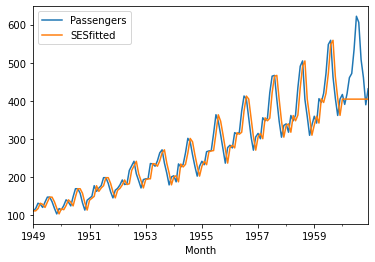

In [20]:
# --> ML problem
# split up data set into training test --> forecast
# trainset anything before last 12 data points --> test set = last 12 data points

N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

# fit function without alpha ou optimized = false, 
# find best alpha, minimised error over train set

ses = SimpleExpSmoothing(train['Passengers'])
res = ses.fit()

# assign prediction to original df model

df.loc[:-N_test, 'SESfitted'] = res.fittedvalues # from 0 to -N_test
df.loc[-N_test:, 'SESfitted'] = res.forecast(N_test) # from -N_test to end
df[['Passengers', 'SESfitted']].plot()

# forecast = horizontal line, train_set is lagging behind by 1 step
# alpha close to 1 as reacting very quickly to original ts

In [21]:
# alpha
res.params # --> 0.995 close to 1

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Holt Linear Trend Model

In [22]:
from statsmodels.tsa.holtwinters import Holt

holt = Holt(df['Passengers'])
res_h = holt.fit()
df['Holt'] = res_h.fittedvalues

df[['Passengers', 'Holt']].plot()

# similar to previous model..

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


<AxesSubplot:xlabel='Month'>

<AxesSubplot:xlabel='Month'>

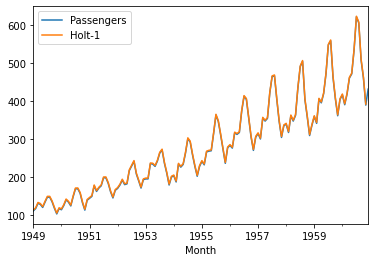

In [23]:
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers', 'Holt-1']].plot()

# values line up
# However, it is wrong to do this --> forecasting model different from Holt, forecasting time index moved up by 1 step
# Holt is represented by level but prediction ^y is assigned to level of previous time step --> original was correct

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Emilie Berger\anaconda3\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)
C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Month'>

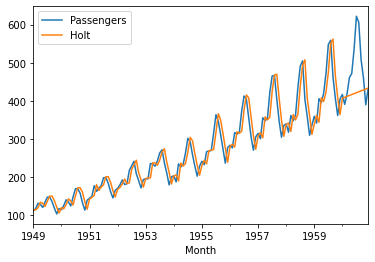

In [24]:
# use train test split again --> real forecast

holt = Holt(train['Passengers'])
res_h = holt.fit()
df.loc[:-N_test, 'Holt'] = res_h.fittedvalues
df.loc[-N_test:, 'Holt'] = res_h.forecast(N_test)

df[['Passengers', 'Holt']].plot()

#straight line trending upwards --> exactly what holt should do

### Holt-Winters

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Emilie Berger\anaconda3\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)
C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Month'>

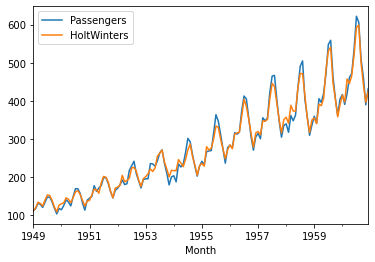

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# create model instance, skip right away to train test split
# additive trend and seasonality, season period = 12 --> data cycle = yearly and data frequency = monthly

hw = ExponentialSmoothing(train['Passengers'], \
                         trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)

df[['Passengers', 'HoltWinters']].plot()

# fits very well for both train/test, not lagging behind time series
# confirms that correct to shift -1

In [26]:
# Now that it fits very well --> calculate some metrics

# root mean squared error
# y = predictions, t = targets
def rmse(y, t):
    return np.sqrt(np.mean((y - t)**2))

# absolute error --> models minimize squared error directly
def mae(y, t):
    return np.mean(np.abs(y - t))

# check rmse and mae on train/tes sets

print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Train RMSE: 11.62469954262423
Test RMSE: 16.981141615502576
Train MAE: 9.011203838180053
Test MAE: 13.382207171715427


C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Emilie Berger\anaconda3\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


<AxesSubplot:xlabel='Month'>

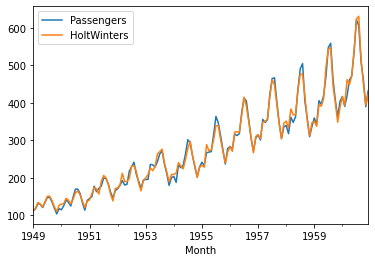

In [27]:
# try again with different parameters
# As cycle amplitude increases with TS level
# --> multiplicative model may fit better
# multiplicative seasonality

hw = ExponentialSmoothing(train['Passengers'], \
                         trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()

df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)

df[['Passengers', 'HoltWinters']].plot()

# seems to fit even better

In [28]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

# rmse better for train, worse for test
# mae better for both

Train RMSE: 9.768020481856624
Test RMSE: 15.809890178532703
Train MAE: 7.604221246063918
Test MAE: 10.302594878699557


C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Emilie Berger\anaconda3\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


<AxesSubplot:xlabel='Month'>

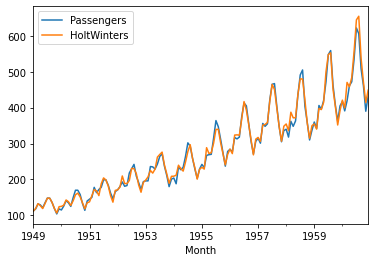

In [29]:
# multiplicative trend

hw = ExponentialSmoothing(train['Passengers'], \
                         trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()

df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)

df[['Passengers', 'HoltWinters']].plot()

# hard to tell if better

In [30]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

# rmse better for train, much worse for test
# mae better for train, much worse for test

Train RMSE: 9.617924831716339
Test RMSE: 25.81135901063159
Train MAE: 7.11238634958478
Test MAE: 20.84917774687902


C:\Users\Emilie Berger\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
